## Background
This is a data challenge with insight data. All I know is that various companies and departments have measures of employees quitting (plus some covariates), and we should analyze the data to provide insights into "churn"

### Challenge Description
We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as average salary during her tenure, department, and years of experience. As said above, the goal is to predict employee retention and understand its main drivers

### Goals:
+ What are the main factors that drive employee churn? Do they make sense? Explain your findings.
+ What might you be able to do for the company to address employee Churn, what would be follow-up actions?
+ If you could add to this data set just one variable that could help explain employee churn, what would that be?
+ Your output should be in the form a a jupyter notebook and pdf output of a jupyter notebook in which you specify + your results and how you got them.

### Data
The table is:

+ "employee_retention" - comprehensive information about employees. Columns:
+ employee_id : id of the employee. Unique by employee per company
+ company_id : company id.
+ dept : employee department
+ seniority : number of yrs of work experience when hired 
+ salary: average yearly salary of the employee during her tenure within the company
+ join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
+ quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

In [2]:
# get the data in Python
%matplotlib inline
import os
import pandas as pd
import numpy as np
import rpy2
from matplotlib import pyplot as plt
from rpy2.robjects import r # for managing
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
gr = importr("graphics")
rbase = importr("base")
s = importr("stats")
m = importr("mboost")
surv = importr("survival")
 
##### 
# set the working directory
#wd = "/"
#os.chdir(wd)


# Data import and Clean-up
The data is located in `employee_retention.csv`.
Aside from some mis-matches in dating format, and some problematic temporary contractors, the data importation is relatively straightforward.

In [3]:
# import the data
d = pd.read_csv("employee_retention.csv")

# fix issues with the date (two formats: desired: YYYY-MM-DD vs DD.MM.YYYY)
which_date2 = ~d['join_date'].str.contains('....-..-..', regex=True)
for row,dstr in zip(np.where(which_date2),d['join_date'][which_date2]):
    dstrsplt = dstr.split(".")
    d['join_date'][row] = dstrsplt[2]+"-"+dstrsplt[0]+"-"+dstrsplt[1]

# specify the max possible 
max_date = "2015-12-13" #
censored_dates = d['quit_date'].fillna("2019-01-01")
d['yes_quit'] = 1*(censored_dates != "2019-01-01")
d['quit_date'][np.where(censored_dates == "2019-01-01")[0]] = max_date
del censored_dates
 
# fix some problems with the dates
d['join_date'] = pd.to_datetime(d['join_date'], format="%Y-%m-%d")
d['quit_date'] = pd.to_datetime(d['quit_date'], format="%Y-%m-%d")

# calculate the time to event
d['time_to_event'] = (d['quit_date'] - d['join_date']).astype('timedelta64[h]')

# delete the Temporary Workers (left because of end of contact)
d = d.loc[(d.dept != "temp_contractor")]

# delete the missing values
d = d.dropna()
d.shape


/home/rob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(24463, 10)

# Exploration
Let's inspect the marginal distributions.
It looks like some funny business is going on with seniority. We should clip the high values to get a more normal distribution.

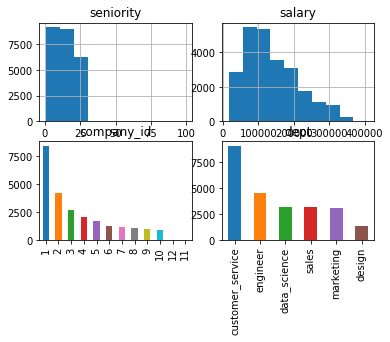

In [4]:
from matplotlib import pyplot as plt
plt.figure()
plt.subplot(2, 2, 1)
d.seniority.hist() 
plt.title("seniority")
plt.subplot(2, 2, 2)
d.salary.hist()
plt.title("salary")
plt.subplot(2, 2, 3)
d['company_id'].value_counts().plot(kind='bar')
plt.title("company_id") 
plt.subplot(2, 2, 4)
d['dept'].value_counts().plot(kind='bar')
plt.title("dept") 
plt.show()


# Features/Scaling
Basic unit-variance and mean-centering of the continous covariates

In [5]:
# Feature engineering (very basic scaling, standardizations) 
# scale the continuous data
def scaler(X,log=False,clip_low=None, clip_hi = None):
   if clip_low!=None: 
      Xclip = X.clip(clip_low, clip_hi)
   else:
      Xclip = X
   if log==True:
      Xclip = np.log(Xclip)
   return (Xclip-np.mean(Xclip))/pow(np.var(Xclip),0.5)

# re-scale salary: mean-centre and unit-variance
d['salary'] = scaler(d['salary'].values)
# re-scale senorioriy: clip to compress extreme values
#d['seniority'] = scaler(d['seniority'].values,log=False)
d['seniority'] = scaler(d['seniority'].values,log=False,clip_low=d['seniority'].min(), clip_hi =d['seniority'].quantile(0.99))


# Prep Data for R

In [6]:
# Prep data for R 
r_df = pandas2ri.py2ri(d) # import panda dataframe into R dataframe
r.assign("rdata", pandas2ri.py2ri(d))

# ensure proper R 'factor' format for categorical data
r("rdata$dept <- factor(rdata$dept)")
r("rdata$company_id <- factor(rdata$company_id)")


[8, 3, 2, 5, 3, ..., 6, 2, 5, 3, 2]
Length: 24463
Categories (12, object): [1, 2, 3, 4, ..., 9, 10, 11, 12]

# Survival Analysis: Mboost: Accelerated Time Failure Modelling
Boosting is a type of functional gradient descent and ensemble building. 
In this model, I will use "component-wise boosting" which lets different covariates and "learners" compete to enter the ensemble. Under limited cases, it nearly-equivalent to a Lasso solution, which means:
+ automatic variable selection
+ optimal predictive accuracy through "shrinkage" and feature-selection (through hyperparameter tuning)
+ negotiates the bias-variance trade-off (another way of saying the above).

For more information on statistical boosting, check out my [blog article Boosting Deep-Dive](http://colugos.blogspot.com/2018/10/boosting-deep-dive-from-mles-to.html)

The key components in the following analysis are:
+ `bols`: least squares learners
+ `btree`: "stump" decision trees
+ `bbs`: P-splines

... plus various interaction. We specify these in an R formula. Some of this looks like:
+ `bols(interc,intercept=FALSE)` : intercept
+ `bols(salary,by=dept,df=8)` : salary x department interaction (linear)
+ `bbs(salary,by=dept,df=12)` : salary x department interaction (spline)
+ `bols(company_id,df=6)`: company main effect
+ `bols(dept,df=6)` : department main effect
+ `btree(seniority)` : non-linear seniority effect
+ `bols(salary, by=company_id, df=8)` : salary by company interaction (linear)
+ `bbs(salary,by=company_id,df=25)` : salary by company interaction (spline)
+ ...



We will run the algorithm for 100 iterations and a learning rate of 0.1. After, this `mstop` hyperparameter will need tuning via bootstrap-validation.

In [40]:
# run boosting models: Accelerated Time-Failure model with Weibull Distribution
# mboost has better survival analysis tools than anything available in python
# mboost: offers flexible model-based boosting for a variety of loss functions, including Weibull 
# ... models for Accelerated Time-Failure model

# model 1: liberal model (lots of interactions among covariates)
r("formu.1 <- Surv(time=time_to_event, event=yes_quit) ~ bols(interc,intercept=FALSE) + btree(seniority) + btree(salary) + bols(company_id,df=6) + bols(dept,df=6) +  bols(dept,by=company_id, df=6)+ bols(seniority,by=dept,df=8) + bbs(seniority,by=dept,df=12) + bols(seniority, by=company_id, df=8) +bbs(seniority,by=company_id,df=25) + bols(salary) + bbs(salary,df=4) + bols(salary,by=dept,df=8) + bbs(salary,by=dept,df=12) + bols(salary, by=company_id, df=8) + bbs(salary,by=company_id,df=25)")
r("m.1 <- mboost(formu.1, data=data.frame(cbind( interc = rep(1,nrow(rdata)), rdata)), family = Weibull(), control=boost_control(nu=0.05,mstop=100))")

# restricted model: focused on salary (after results of model.1)
r("formu.2 <- Surv(time=time_to_event, event=yes_quit) ~ bols(interc,intercept=FALSE) + btree(seniority) + bols(company_id,df=6) + bols(dept,df=6) + bols(seniority,by=dept,df=8) + bbs(seniority,by=dept,df=12) + bols(seniority, by=company_id, df=8) + bols(salary,by=dept,df=8) + bbs(salary,by=dept,df=12) + bols(salary, by=company_id, df=8) + bbs(salary,by=company_id,df=25)")
r("m.2 <- mboost(formu.2, data=data.frame(cbind( interc = rep(1,nrow(rdata)), rdata)), family = Weibull(), control=boost_control(nu=0.05,mstop=100))")



R object with classes: ('mboost',) mapped to:
<ListVector - Python:0x7fd8fc42bc48 / R:0xaa17e40>
[ListVector, ListVector, FloatVector, FloatVector, ..., Signature..., Signature..., Signature..., Vector]
R object with classes: ('mboost',) mapped to:
<ListVector - Python:0x7fd8fc42bc48 / R:0xaa17e40>
[ListVector, ListVector, FloatVector, FloatVector, ..., Signature..., Signature..., Signature..., Vector]
R object with classes: ('mboost',) mapped to:
<ListVector - Python:0x7fd8fc42bc48 / R:0xaa17e40>
[ListVector, ListVector, FloatVector, FloatVector, ..., Signature..., Signature..., Signature..., Vector]
  offset: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7fd8fc42b6c8 / R:0x15c294a8>
[10.476911]
  ustart: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7fd8fc412488 / R:0x1e4d91e0>
[-1.464854, -0.584147, -1.150183, 0.311680, ..., 1.935772, -1.135170, -1.034293, -1.097941]
...
  family: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7fd8fc4401c8 / R:0x10944710>
  response: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7fd8fc440548 / R:0x1083b3b0>
  rownames: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7fd8fc440ac8 / R:0x10b01690>
  (weights): <class 'rpy2.robjects.vectors.Vector'>
  R object with classes: ('mboost',) mapped to:
<Vector - Python:0x7fd8fc440d08 / R:0xf5014d0>
[RObject, RObject, Vector, Vector, Vector]

# Hyperparameter Tuning: Bootstrap Validation
I'll use a 25-fold bootstrap validation to tune the key hyperparameter `mstop`. The bootstrap maintains the same amount of data as our real dataset, while validating on about 36 percent of the holdout (out of bootstrap) sample.
The R function `cvrisk` takes care of this for us.

In [42]:
# use bootstrap validation to tune the hyperparameters (mstop)
__ = r("n <- nrow(rdata)")
__ = r("bs25 <- rmultinom(25, n, rep(1, n)/n)")

# bootstrap validation: 25 bootstrap runs
__ = r("cvm.1 <- cvrisk(m.1, folds = bs25, papply = lapply)") # model 1 bootstrap
__ = r("cvm.2 <- cvrisk(m.2, folds = bs25, papply = lapply)") # model 1 bootstrap

# get the best boosting step
ExpectedError1 = r("min(colMeans(cvm.1))")
ExpectedError2 = r("min(colMeans(cvm.2))")
best_model = r("which.min(c(min(colMeans(cvm.1)),min(colMeans(cvm.2))))")

print("The better model is model %d" % best_model)

The better model is model 1


In [43]:
# refit the best model at it's optimal stopping iteration (mstop)
r("bestm <- which.min(colMeans(cvm.1))")
r("m.weib <- cvm.1[bestm]")

array([0.91131947])

The optimal number of booting steps is small: only 34. This is NOT a very predictive model.

# Variable Importance
How much does each covariate/learner contribute to the 'risk-reduction' (like proportion of variance-explained)? We see that Salary explains the most of the risk-reduction followed by a time-amount by salary x company.


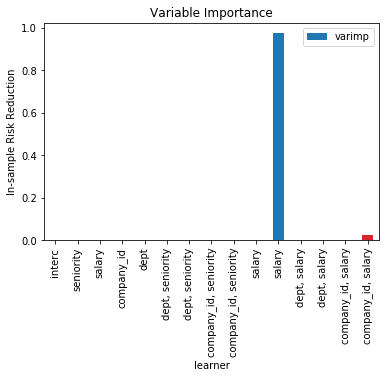

In [37]:
# get variable importance measures
__ = r("vimp <- varimp(m.weib)")
varimp_names = r("attr(vimp,'variable_names')")
varimp = pd.DataFrame({"varimp": r("vimp"),"learner":varimp_names.tolist()})
# calculate in-bag risk-reduction (% explained variance)
varimp.varimp = varimp.varimp/varimp.varimp.sum()

# PLOT: barplot of variable importance (Proportion of in-sample risk reduction
varimp.plot.bar(x = "learner", y = "varimp")
plt.ylabel("In-sample Risk Reduction")
plt.title("Variable Importance") 
plt.show()


# Marginal Effects: role of each covariate
We will look at the functional relationship between probability of quitting and the covariates. (Unfortunately, inline plotting with R+Python is tricker, so the next few lines of code are wonky, sorry!).


NULL



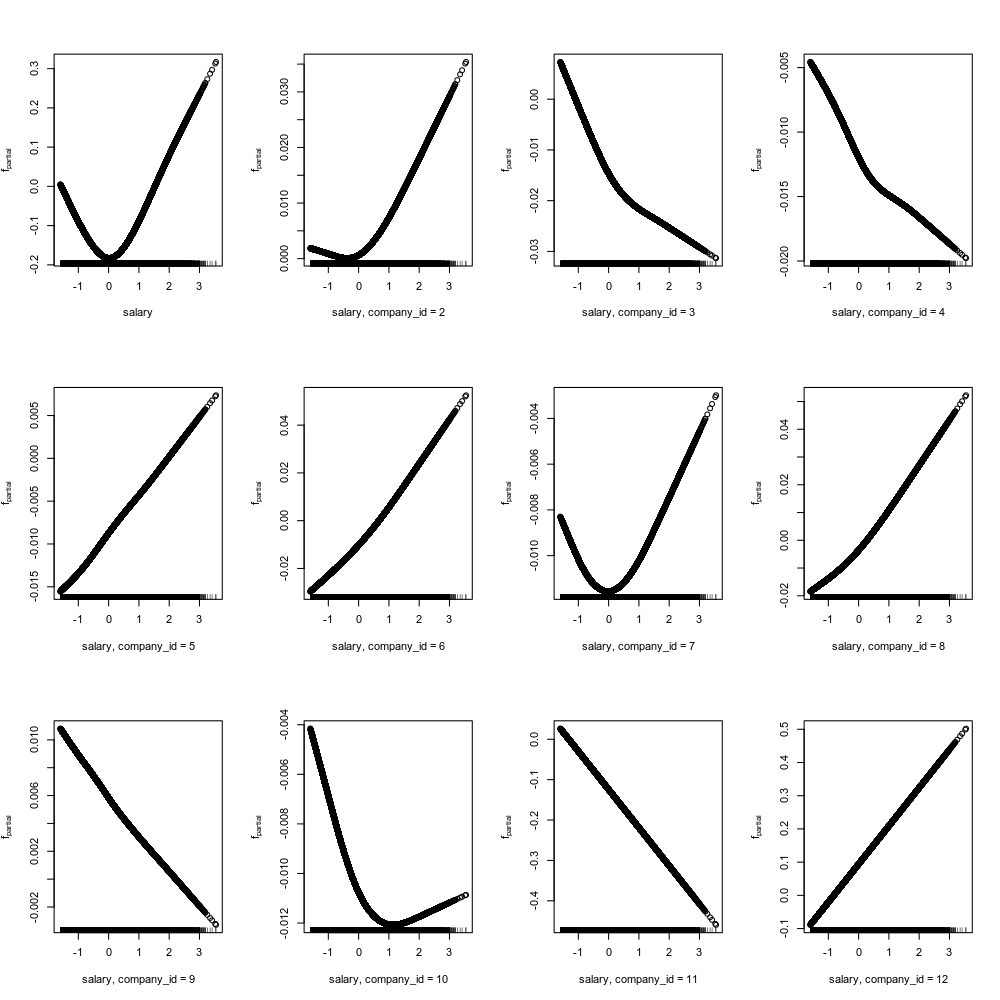

In [38]:
# Plotting the marginal Effects
# (the following is a terrible kluge to try and do an inline plot in jupyter notebooks with R)
# ... usually in R, the command would simply be: > par(mfrow=c(4,5)); print(plot(m.weib))
from rpy2.robjects.lib import grdevices

with grdevices.render_to_bytesio(grdevices.png, width=1000,height=1000, res=100) as b:
   r("par(mfrow=c(3,4)); print(plot(m.weib))")

from IPython.display import Image, display
data = b.getvalue()
display(Image(data=data, format='png', embed=True))
# end inline-R-plot kluge


# Results of Marginal Plots
+ Company 12 has the biggest problem (last plot). It has the strongest relationship between increasing salary and increasing turnover. However, there is very little data for company 12, so this is less trustworthy.
+ most other companies have little idiosyncratic turnover
+ Globally, there is a U shaped relationship between turnover and salary: there is higher turnover at the higher-paid salaried employers, and higher turnover at the low-end.
+ other covariates ARE NOT predictive: they lead to overfitting

# Model Inspection: Residual plots and Unexplained Variation
The model is tuned by cross-validation, therefore we are comfortable that it isn't overfitting. But, the residuals show a strange pattern: there is a large group of individuals quitting after 7000 hours (or 290 days). It is almost as if there was a massive amount of "restructuring" or lay-offs or buyouts, or some giant, quick turnover. Is there some program that only retains people for only 3 quarters??

[[1.         0.11201663]
 [0.11201663 1.        ]]


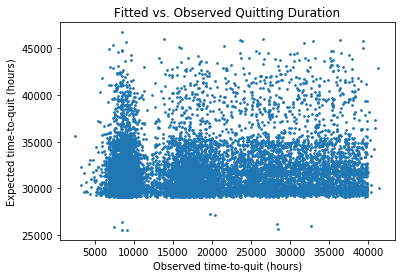

In [39]:
# get the predicted values and plot
vPred = r("m.weib$fitted()")

# print the correlation between the Fitted and the actual time-to-quitting durations
print(np.corrcoef(d.time_to_event[d.yes_quit==1], np.exp(vPred[d.yes_quit==1])))

# plot the relationship between the fitted and actualtime-to-quitting durations
plt.scatter(d.time_to_event[d.yes_quit==1], np.exp(vPred[d.yes_quit==1]),s=3)
plt.title("Fitted vs. Observed Quitting Duration")
plt.ylabel("Expected time-to-quit (hours)")
plt.xlabel("Observed time-to-quit (hours)")
plt.show()


# Conclusions
+ A U-shaped relationship between salary and turnover: higher salary = higher turnover, and likewise at the lower end
+ Overall the model has little explanatory power
+ There is a mysterious mass quitting going on at 290 days. Is there some program/internship/co-op-student that is causing this pattern? Was there some majority restructuing or labour-change that caused this spike?
+ Despite the allure of other explanatory factors (like department), these donot seem to have consistent, predictive power, and likely result in overfitting.